# Imports

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import os

from hygeia.utils.hplots import violin_plot

# Params

In [2]:
adata_path = '../../Datasets/preprocessed_datasets/kang.h5ad'
covariate_name = 'cell_type'
condition_name = 'condition'
stim_name = 'stimulated'
control_name = 'control'

# Read Original data

In [3]:
adata = sc.read_h5ad(adata_path)

In [4]:
ood_cov = 'B'
split_key = f'split_{stim_name}_{ood_cov}'

adata_gt = adata[adata.obs[split_key] == 'ood'].copy()
adata_ctrl = adata[(adata.obs[covariate_name] == ood_cov) & (adata.obs[condition_name] == 'control')].copy()

# Read Predictions

In [5]:
adata_preds = sc.read_h5ad(
    f'../../Benchmarks/SCDISENTANGLE/Kang/predictions/kang/{ood_cov}_6.h5ad'
)

adata_preds = adata_preds[
    adata_preds.obs[f'{condition_name}_pred'] == stim_name
]

/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
adata_preds.X.max(), adata_preds.X.min(), adata_preds.shape

(array(1063.5862, dtype=float32), array(0., dtype=float32), (542, 13404))

# Normalize

In [7]:
sc.pp.normalize_total(adata_gt)
sc.pp.log1p(adata_gt)

adata.X seems to be already log-transformed.


In [8]:
sc.pp.normalize_total(adata_ctrl)
sc.pp.log1p(adata_ctrl)

adata.X seems to be already log-transformed.


In [9]:
sc.pp.normalize_total(adata_preds)
sc.pp.log1p(adata_preds)

/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


# Plot

In [10]:
adata_ctrl.obs['custom_label'] = f'Observed {control_name}'
adata_gt.obs['custom_label'] = f'Observed {stim_name}'
adata_preds.obs['custom_label'] = f'Predicted {stim_name}'

adata_cat = adata_ctrl.concatenate(adata_gt, adata_preds)

/tmp/ipykernel_2296553/239448744.py:5: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_cat = adata_ctrl.concatenate(adata_gt, adata_preds)


In [11]:
label_color_dict = {
    f'Observed {control_name}': '#708090',
    f'Observed {stim_name}':'#FFC0CB',
    f'Predicted {stim_name}':'#d62728',
}

In [12]:
save_dir= f'/data/scDisentangle figures/Kang/violinplots'
os.makedirs(save_dir, exist_ok=True)

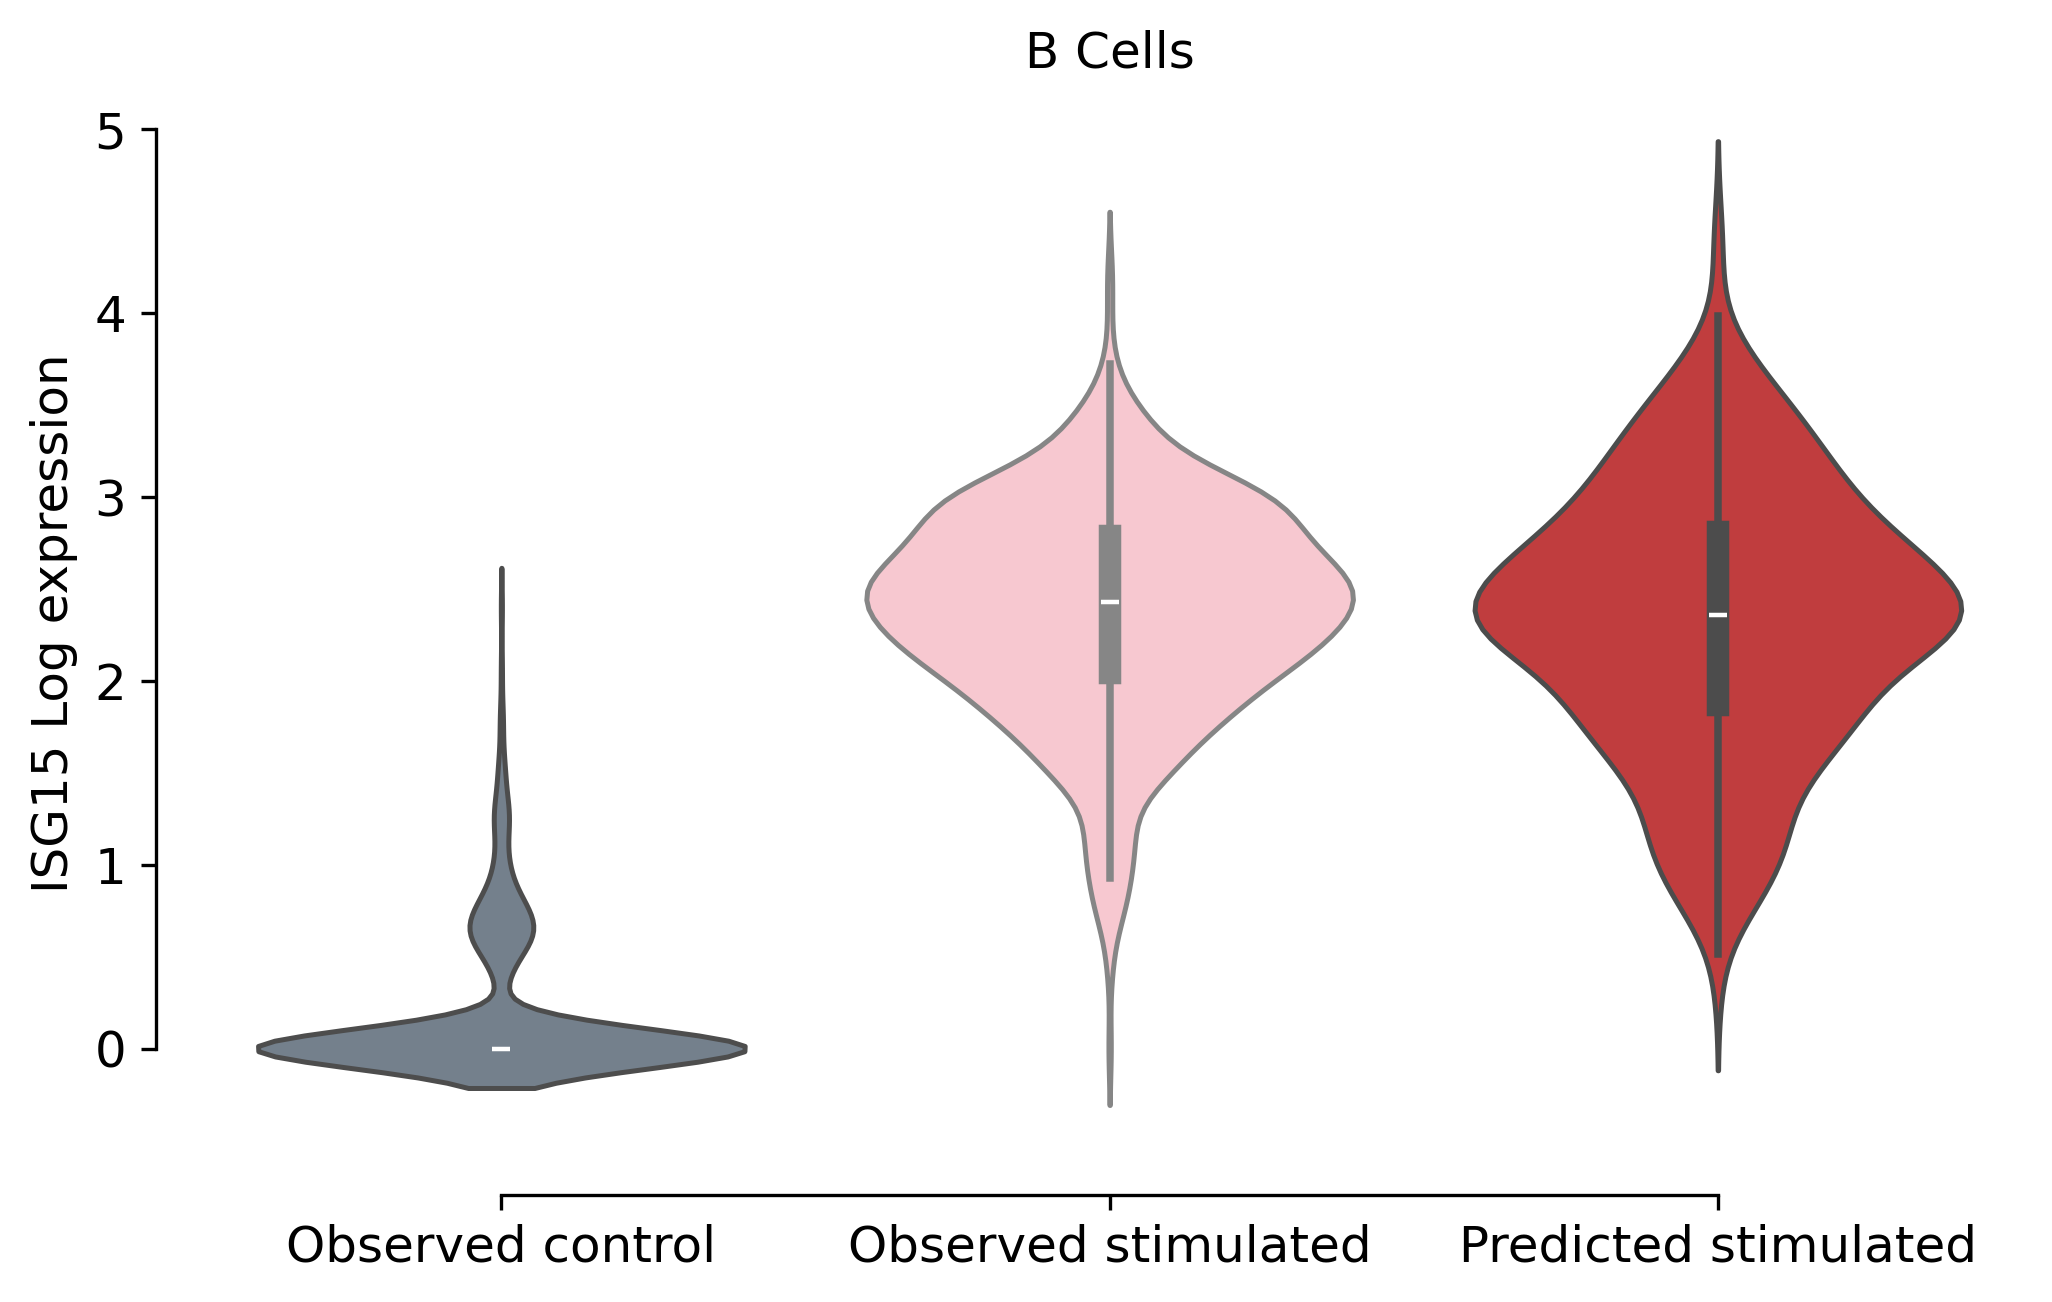

In [13]:
violin_plot(
    adata=adata_cat,
    variable_of_interest='ISG15',
    label_column_name='custom_label',
    title=f'{ood_cov} Cells',
    x_name='',
    y_name='ISG15 Log expression',
    violin_color='Black',
    figsize=(7, 4.5),
    label_color_dict=label_color_dict,
    save_path=f'{save_dir}/{ood_cov}',
    inner='box',
    rotation=0,
    despine=True
)

# Significance

In [14]:
from scipy.stats import ttest_ind

In [15]:
gene_name = 'ISG15'
adata_cat = adata_cat[adata_cat.obs['cell_type'] == ood_cov]

pred = adata_cat[adata_cat.obs['custom_label'] == 'Predicted stimulated'][:, gene_name].X.squeeze()
gt = adata_cat[adata_cat.obs['custom_label'] == 'Observed stimulated'][:, gene_name].X.squeeze()
ctrl = adata_cat[adata_cat.obs['custom_label'] == 'Observed control'][:, gene_name].X.squeeze()

In [16]:
ttest_ind(pred, gt)[1]

0.18552534199282747

In [17]:
ttest_ind(pred, ctrl)

TtestResult(statistic=63.010784184147205, pvalue=0.0, df=1132.0)